In [1]:
using Random, Statistics, Polynomials

In [2]:
using Plots
#using PyPlot
#using Makie

# 1. Implementation for MC algorithm using wolff cluster for xy model in 2d

Based on the code from recitation 8

In [3]:
# Structure representing a 2D point with integer coordinates
struct Point2D
    x::Int64
    y::Int64
end

# Structure representing a square lattice with specified dimensions
struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

# Calculate the total number of sites in the lattice
import Base.length
function length(lat::SquareLattice)
    return lat.Nx * lat.Ny
end

# Convert a 2D point on the lattice to a linear index
function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y - 1) * lat.Nx + r.x
end

# Convert a linear index to a 2D point on the lattice
function IndexToPoint(lat::SquareLattice, ind::Int64)
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind - 1, lat.Nx) + 1
    x = mod(ind - 1, lat.Nx) + 1

    return Point2D(x, y)
end
    
# Find the linear indices of the nearest neighbors of a site on the lattice
function NearestNeighbors(lat::SquareLattice, ind::Int64)
    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64, 4)
    
    xp = mod(r.x, lat.Nx) + 1
    yp = mod(r.y, lat.Ny) + 1
    xm = mod(r.x - 2, lat.Nx) + 1
    ym = mod(r.y - 2, lat.Ny) + 1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y)) # Left neighbor
    nn[2] = PointToIndex(lat, Point2D(xp, r.y)) # Right neighbor
    nn[3] = PointToIndex(lat, Point2D(r.x, ym)) # Upper neighbor
    nn[4] = PointToIndex(lat, Point2D(r.x, yp)) # Lower neighbor
    
    return nn
end;

In [4]:
function IsingConfigurationEnergy(lat::SquareLattice, c::Vector{Float64})
    # Calculate the energy of an Ising configuration on a square lattice.
    
    N = length(lat)
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    Ec = 0.
    
    for j in range(1, length = N)
        nn = NearestNeighbors(lat, j)
        # Energy contribution from the current site
        bond_energy = -sum(cos.(c[nn].-c[j]))
        Ec += bond_energy
    end
    return Ec/2  # In the summation above, every bond is included twice
end;

In [5]:
function calcMagnetization(c)
    Sx = cos.(c)
    Sy = sin.(c)
    Mx = mean(Sx)
    My = mean(Sy)
    return sqrt(Mx^2+My^2)
end;

In [6]:
function IsingMC(lat::SquareLattice, T::Float64, Nsw::Int64, clusterUpdates = false, saveConfigs = false)
    # Perform Ising Monte Carlo simulations.

    # Parameters:
    # - `lat`: SquareLattice object representing the lattice.
    # - `T`: Temperature.
    # - `Nsw`: Number of sweeps to perform.
    # - `clusterUpdates`: Perform cluster updates if true, single-spin updates if false.
    # - `saveConfigs`: Save configurations at each sweep if true.

    c = rand(length(lat))*2*π  # Initialize random spin configuration.
    if saveConfigs
        configs = zeros(Float64, Nsw, length(lat))  # Matrix to store configurations at each sweep.
        configs[1, :] = c  # Save initial configuration.
    end
    
    m = zeros(Float64, Nsw)  # Array to store magnetization at each sweep.
    m[1]= calcMagnetization(c)
    
    En = zeros(Float64, Nsw)  # Array to store energy at each sweep.
    En[1] = IsingConfigurationEnergy(lat, c)  # Initial energy.
    
    for i in range(2, stop=Nsw)  # Loop over sweeps.
        
        if clusterUpdates
            IsingWolffUpdate!(lat, c, T)  # Perform cluster update.
            En[i] = IsingConfigurationEnergy(lat, c)  # Calculate new energy.
        else
            @assert false
            dEi = IsingMetropolisSweep!(lat, c, T)  # Perform single-spin Metropolis update and get energy change.
            En[i] = En[i-1] + dEi  # Update total energy.
        end
        
        if saveConfigs
            configs[i, :] = c  # Save current configuration.
        end

        m[i]= calcMagnetization(c)

    end
    
    if saveConfigs
        return m, En, configs
    else
        return m, En
    end
    
end;

# Cluster updates

In [99]:
c = [0 ,0 ,0 ,0]
i =1
j= 2
T=0.00001
random_θ=rand()*2*π
p = 1.0 - exp(minimum([0,-2*cos(c[i]-random_θ)*cos(c[j]-random_θ)/T]))

1.0

In [166]:
function IsingWolffUpdate!(lat::SquareLattice, c::Vector{Float64}, T::Float64)

    N = length(lat)
    
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    random_θ = rand()*2*π
    i = rand(1:N) # pick a random site
    
    cluster = Int64[] # indices of spins in the cluster
    newlyAdded = Int64[] # indices of newly added neighbors

    push!(cluster, i)
    append!(newlyAdded, NearestNeighbors(lat, i))

    while !isempty(newlyAdded)
        j = pop!(newlyAdded)
        if j in cluster
            continue
        end
        p = 1.0 - exp(minimum([0,-2*cos(c[i]-random_θ)*cos(c[j]-random_θ)/T]))
        if rand() < p
            push!(cluster, j)
            nn = NearestNeighbors(lat, j)
            append!(newlyAdded, nn)
        end
    end

    #c[cluster] = 1 .- c[cluster] # flip the cluster
    #c[cluster] .= mod.(c[cluster] .+ (2*(c[cluster].-random_θ)) .+ π,2*π) # flip the cluster
    x_arr = cos.(c[cluster])
    y_arr = sin.(c[cluster])
    x_arr .= x_arr .- 2*cos(random_θ)*cos.(random_θ .- c[cluster])
    y_arr .= y_arr .- 2*sin(random_θ)*cos.(random_θ .- c[cluster])
    c[cluster] .= mod.(angle.(x_arr .+ im*y_arr),2*π)
end;

In [167]:
function CalculateError(m, Neq, Nsw)
    # Function to calculate the error in the mean magnetization using binning analysis
    
    err = Float64[]

    # Determine the number of sweeps for error analysis
    Nsw2 = 2^Int(floor(log(2, Nsw-Neq))) # closest power of 2 smaller than the number of sweeps after equilibration

    # Extract the last Nsw2 magnetization values for error analysis
    ml = m[end-Nsw2+1:end]

    # Set the minimum size for the moving block (binning) analysis
    min_size = 2^5

    # Perform the moving block (binning) analysis
    while length(ml) > min_size
        # Compute the standard error of the mean and append to the error array
        push!(err, std(ml) / sqrt(length(ml) - 1))

        # Reduce the size of the data by taking the mean of consecutive pairs (binning)
        ml = map(j -> mean(ml[2*j-1:2*j]), range(1, stop=div(length(ml),2)))
    end

    return err
end;

# 2. 

In [180]:
N = 32
lat = SquareLattice(N,N)
Nsw = 100000
#T_arr = [0.1 , 0.5 , 0.8, 1. , 1.2 , 1.5, 2. , 5.]
T_arr = [0.1, 1., 1.5]
m_arr = fill(zeros(Float64, Nsw), length(T_arr))
En_arr = fill(zeros(Float64, Nsw), length(T_arr))
configs_arr = fill(zeros(Float64, Nsw, length(lat)), length(T_arr))

for (i,T) in enumerate(T_arr)
    @time m_arr[i] , En_arr[i], configs_arr[i] = IsingMC(lat, T, Nsw, true, true)
end;

152.920018 seconds (487.48 M allocations: 57.606 GiB, 4.18% gc time)
 78.623128 seconds (398.22 M allocations: 41.019 GiB, 6.61% gc time)
 29.903188 seconds (313.20 M allocations: 30.348 GiB, 4.24% gc time)


In [194]:
T=0.0001
@time m , En, config = IsingMC(lat, T, Nsw, true, true)

146.443687 seconds (513.59 M allocations: 62.887 GiB, 2.36% gc time)


([0.02847450298569058, 0.08835143529821887, 0.22485326977564493, 0.5180923210078864, 0.4782754055295529, 0.6231317340052032, 0.6379005156140116, 0.6416574791086384, 0.6496990802458568, 0.6876978949594821  …  0.9999888040349698, 0.9999888040349698, 0.9999888040349697, 0.9999888040349699, 0.9999888040349698, 0.9999888040349699, 0.9999888040349699, 0.9999888040349697, 0.99998880403497, 0.9999888040349696], [5.593528104643301, -87.644331027872, -300.4473377103253, -742.1981236971841, -797.8102780991737, -987.2003691127785, -1016.9021212938118, -1036.2709433106327, -1055.8823201431048, -1150.588049301703  …  -2047.9710122030847, -2047.9710122030847, -2047.9710122030847, -2047.9710122030847, -2047.9710122030847, -2047.9710122030847, -2047.9710122030847, -2047.9710122030847, -2047.9710122030847, -2047.9710122030847], [1.006274542216165 3.2027397858061404 … 1.4901567302415524 0.23350672812173018; 1.006274542216165 3.2027397858061404 … 1.4901567302415524 0.23350672812173018; … ; 1.5278122178787

T=0.0001, equalibrium times time: 216.0


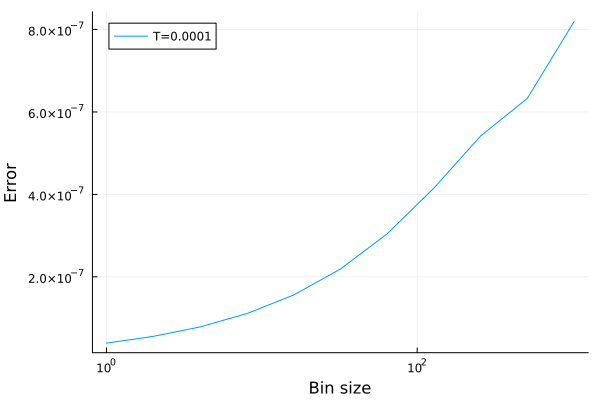

In [198]:
Neq = 0
err = CalculateError(m, Neq, Nsw)
equalibrium_time = round(((err[end]/err[1])^2-1)/2)
println("T=$T, equalibrium times time: ", equalibrium_time )
plot(2 .^ range(0, length= length(err)), err,label="T=$T",ylabel="Error",xlabel="Bin size",xaxis=:log)

T=0.0001, equalibrium times time: 216.0


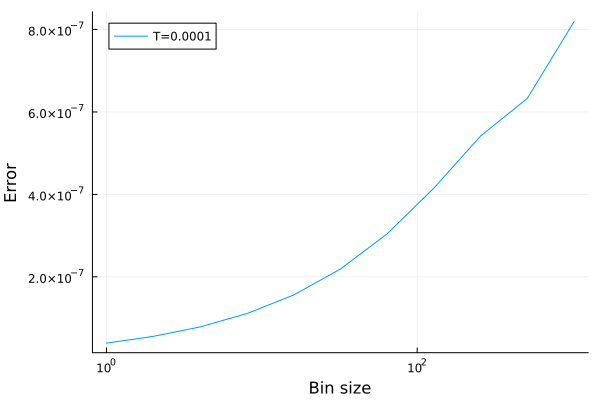

In [200]:
Neq = equalibrium_time*100
err = CalculateError(m, Neq, Nsw)
equalibrium_time = round(((err[end]/err[1])^2-1)/2)
println("T=$T, equalibrium times time: ", equalibrium_time )
plot(2 .^ range(0, length= length(err)), err,label="T=$T",ylabel="Error",xlabel="Bin size",xaxis=:log)

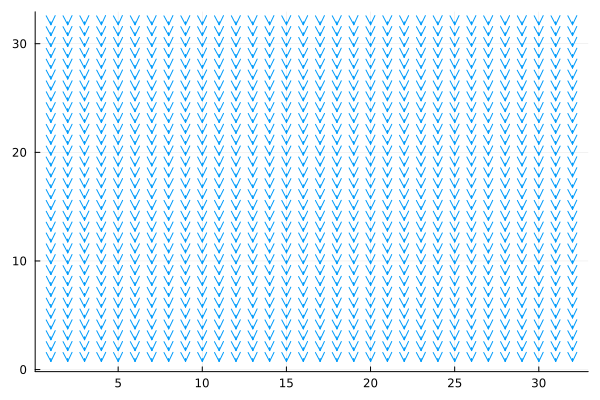

In [197]:
spin_grid = reshape(config[end,:],(N,N))
spins_x = cos.(spin_grid)/4
spins_y = sin.(spin_grid)/4
x = repeat(1:N, N)
y = repeat((1:N)', N)
quiver(x[:], y[:], quiver=(spins_x[:], spins_y[:]))

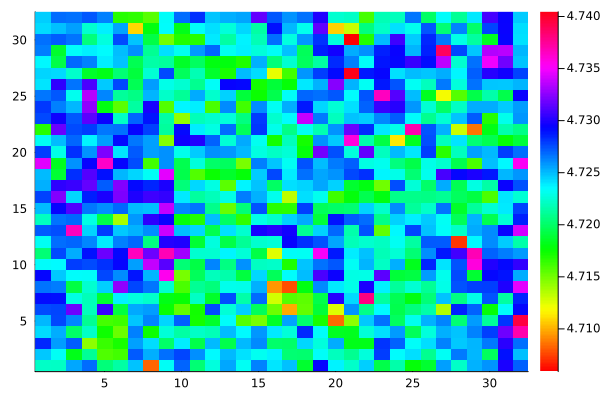

In [201]:
heatmap(reshape(config[end,:],(N,N)),cmap=:hsv)

Finding Equalibrium time (Using Neq=0 and the algorithm for calculating autocorrelation time with it):

T=0.1, equalibrium times time: 13.0
T=1.0, equalibrium times time: 5.0
T=1.5, equalibrium times time: 21.0


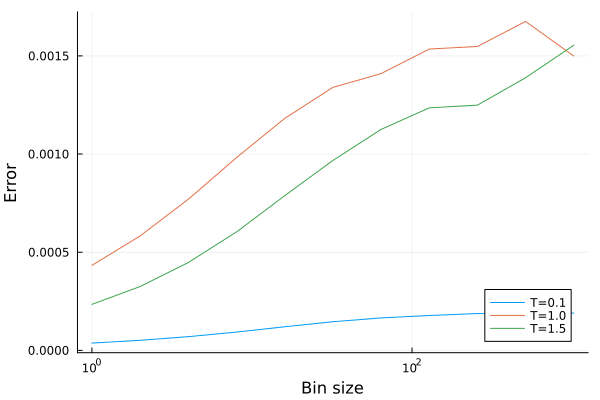

In [183]:
equalibrium_time_arr = zeros(length(T_arr))
plot()
for (i,T) in enumerate(T_arr)
    Neq = 0
    err = CalculateError(m_arr[i], Neq, Nsw)
    equalibrium_time_arr[i] = round(((err[end]/err[1])^2-1)/2)
    println("T=$T, equalibrium times time: ", equalibrium_time_arr[i] )
    plot!(2 .^ range(0, length= length(err)), err,label="T=$T",ylabel="Error",xlabel="Bin size",xaxis=:log)
end;
plot!()

Autocorrelation time (using Neq= 1000*equalibrium_time, as recommended in Troyer 5.5.4 to be much larger than the equalibrium time)

T=0.1, Autocorrelation time: 13.0
T=1.0, Autocorrelation time: 5.0
T=1.5, Autocorrelation time: 21.0


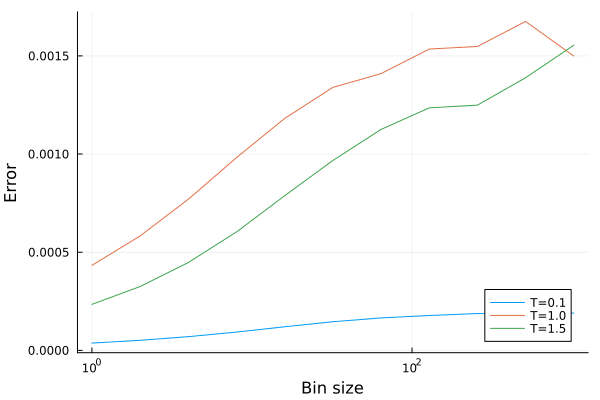

In [184]:
plot()
for (i,T) in enumerate(T_arr)
    Neq = equalibrium_time_arr[i]*100
    err = CalculateError(m_arr[i], Neq, Nsw)
    println("T=$T, Autocorrelation time: ", round(((err[end]/err[1])^2-1)/2) )
    plot!(2 .^ range(0, length= length(err)), err,label="T=$T",ylabel="Error",xlabel="Bin size",xaxis=:log)
end;
plot!()

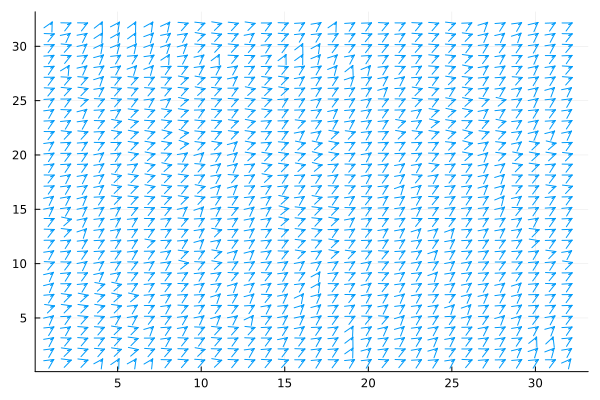

In [182]:
spin_grid = reshape(configs_arr[1][end,:],(N,N))
spins_x = cos.(spin_grid)/4
spins_y = sin.(spin_grid)/4
x = repeat(1:N, N)
y = repeat((1:N)', N)
quiver(x[:], y[:], quiver=(spins_x[:], spins_y[:]))

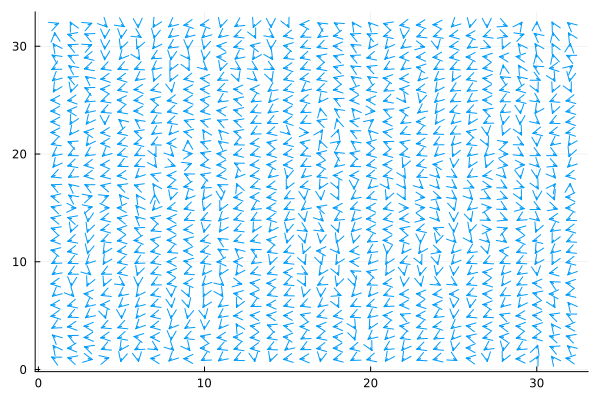

In [185]:
spin_grid = reshape(configs_arr[2][end,:],(N,N))
spins_x = cos.(spin_grid)/4
spins_y = sin.(spin_grid)/4
x = repeat(1:N, N)
y = repeat((1:N)', N)
quiver(x[:], y[:], quiver=(spins_x[:], spins_y[:]))

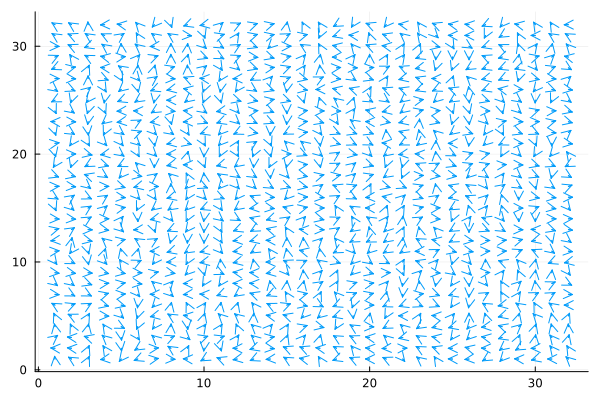

In [186]:
spin_grid = reshape(configs_arr[3][end-2,:],(N,N))
spins_x = cos.(spin_grid)/4
spins_y = sin.(spin_grid)/4
x = repeat(1:N, N)
y = repeat((1:N)', N)
quiver(x[:], y[:], quiver=(spins_x[:], spins_y[:]))

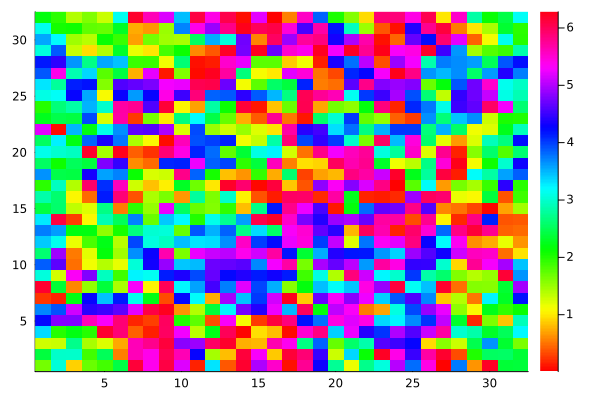

In [236]:
heatmap(reshape(configs_arr[3][end,:],(N,N)),cmap=:hsv)

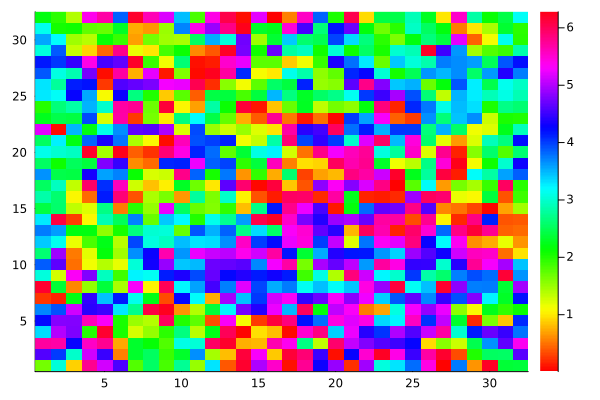

In [249]:
heatmap(reshape(configs_arr[3][end-25,:],(N,N)),cmap=:hsv)

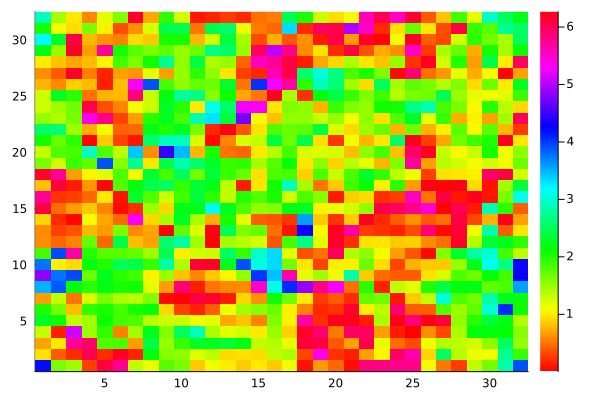

In [237]:
heatmap(reshape(configs_arr[2][end-7,:],(N,N)),cmap=:hsv)

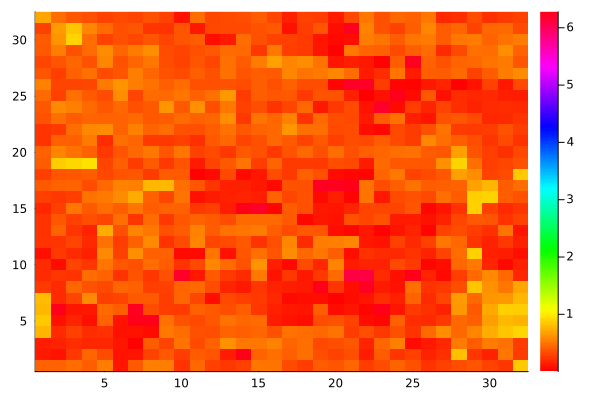

In [229]:
heatmap(reshape(configs_arr[1][end-7,:],(N,N)),cmap=:hsv)

 ## 3. spin-spin correlation function

In [ ]:
function circular_distance(p1, p2, Nx, Ny, manhatan=true)
    dx = abs(p1[1] - p2[1])
    dy = abs(p1[2] - p2[2])

    # Account for wraparound
    dx = min(dx, Nx - dx)
    dy = min(dy, Ny - dy)

    # Use Euclidean distance
    return manhatan ? dx+dy : sqrt(dx^2 + dy^2)
end

In [256]:
function spin_spin_correlation_function(lat::SquareLattice, c::Vector{Float64})
    max_distance= Int(floor(sqrt((lat.Nx/2)^2+(lat.Ny/2)^2)))
    r_arr = [r for r in 0:max_distance]
    c_grid = reshape(c,(lat.Nx,lat.Ny))
    distances_dictionary= Dict()
    for x1 in 1:lat.Nx
        for y1 in 1:lat.Ny
            for x2 in 1:lat.Nx
                for y2 in 1:lat.Ny
                    dist = circular_distance((x1,y1),(x2,y2),Nx,Ny)
                    index1=PointToIndex(lat,Point2D(x1,y1))
                    index2=PointToIndex(lat,Point2D(x2,y2))
                    if haskey(distances_dictonary,dist)
                        distances_dictionary[dist][1] += 1
                        distances_dictionary[dist][2] += cos(c[index1]-c[index2])
                    else
                        distances_dictionary[dist]= (1,cos(c[index1]-c[index2]))
                    end  
        end
    end
    for (i, (key, value)) in enumerate(distances_dictionary)
        println("Element $i is $key: $value")
    end
end;

In [268]:
PointToIndex(lat,Point2D(2,2))

34

In [272]:
for (i, (key, value)) in enumerate(dict)
    println("Element $i is $key: $value")
end

Element 1 is 2.2: 2
Element 2 is 1: 2


In [ ]:
Ls = Int64[8, 16, 24, 32]
Ts = range(0.6, stop=4., step=0.2)

Neq = Int64[100, 100, 200, 200]
Ntot = Neq*100

m = zeros(length(Ts), length(Ls))
dm = zeros(length(Ts), length(Ls))
tau = zeros(length(Ts), length(Ls))

for (j, L) in enumerate(Ls)
    
    lat = SquareLattice(L,L)
    for (k, T) in enumerate(Ts)
        mk, En = IsingMC(lat, T, Ntot[j], true);
        err = CalculateError(mk, Neq[j], Ntot[j])
        m[k,j] = mean(mk[ Neq[j] : end])
        dm[k,j] = err[end]
        tau[k,j] = ((err[end]/err[1])^2-1)/2
    end
end

In [ ]:
fig, ax = subplots(1,2, figsize=(10,3))
for (j, L) in enumerate(Ls)
    ax[1].errorbar(Ts,m[:,j],dm[:,j], marker=".", linestyle="dashed", label="L="*string(L))
end
ax[1].set_xlabel("T")
ax[1].set_ylabel("Magnetization per site");

ax[2].plot(Ts, tau, "--.")
ax[2].set_xlabel("T")
ax[2].set_ylabel("Autocorrelation time");

ax[1].legend()

In [ ]:
ind_Tc = 9
figure(figsize=(4,3))
plot(Ls, tau[ind_Tc,:], "--o")
xlabel("L")
ylabel("Autocorrelation time");
xscale("log")
yscale("log")

p = fit(log.(Ls), log.(tau[ind_Tc,:]), 1)
println("Dynamical critical exponent using Wolff cluster updates is ", round(p[1],digits = 2))